In [ ]:
!pip install tensorflow numpy torch transformers datasets
!pip install tf-keras transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
import numpy as np
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset
from transformers import DataCollatorForLanguageModeling, Trainer, TrainingArguments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://raw.githubusercontent.com/chp36/Recipe-Generator-RNN/refs/heads/main/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(f"Length of text: {len(text)} characters")

--2024-12-02 22:38:31--  https://raw.githubusercontent.com/chp36/Recipe-Generator-RNN/refs/heads/main/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1974250 (1.9M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.88M  --.-KB/s    in 0.06s   

2024-12-02 22:38:31 (33.9 MB/s) - ‘input.txt’ saved [1974250/1974250]

Length of text: 1974250 characters


In [ ]:
# Preprocess the dataset
vocab = sorted(set(text))
vocab_size = len(vocab)
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

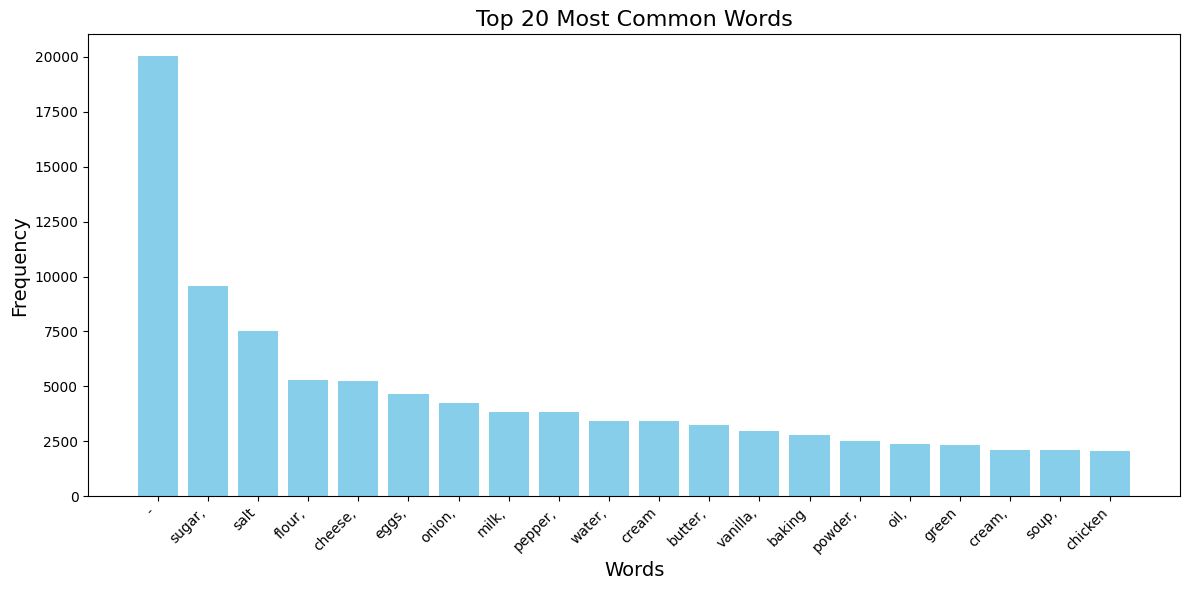

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Example dataset (split your text into words)
words = text.split()

# Count word occurrences
word_counts = Counter(words)

# Get the 20 most common words
most_common = word_counts.most_common(20)

# Separate the words and their frequencies for plotting
common_words, frequencies = zip(*most_common)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(common_words, frequencies, color='skyblue')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Most Common Words', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
def load_dataset(file_path, tokenizer):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=128,
    )
    return dataset

In [ ]:
# Tokenize the Recipes dataset
train_dataset = load_dataset('input.txt', tokenizer)

In [ ]:
print(train_dataset[100])

tensor([21219,    11, 13385,    11,  6701, 28917,    11,  2323, 10904, 12023,
           11,  9653,    11, 21670,    11, 40562,    11,  5894, 33694,    11,
         8268,   532, 47694, 19979, 19145,  6706,  1878,   198,   354,  5973,
        17515,    11, 13385,    11,  3024,  1660,    11,  8566,   286, 28520,
        17141,    11, 17644,    11, 20461, 28716,    11, 27635,  1353, 43672,
           11,  4077, 13385,   532,   520, 18339, 16405, 37476,   198,  1845,
         2001,   259,    11,  7933,  2763,  8469,   263,  1067, 18146,    11,
         1013,  3213,   364,  7543,    11, 11311, 12014,    11,  9215,    11,
        23527,    88, 26636,  9215,   532,  8336,     6,    50,  4333,  2631,
        20651, 18971, 39332,   198,  2833, 18128,    11,  5935,    11, 11676,
         9799,    11, 23972,    11, 13385,    11, 21670,    11,  8566,    12,
         7635, 11676,    11, 35021,    11,  2323, 12023,    11,  4077, 13385,
           11,  8268,   532,  3942, 19145,  6706,  1878,   198])

In [ ]:
# Prepare data collator for training
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Set this to False since GPT-2 doesn't use Masked Language Modeling (MLM)
)

In [ ]:
# Define training arguments for fine-tuning GPT-2
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/gpt2-recipe_titles',
    overwrite_output_dir=True,
    num_train_epochs=3,  # Adjust this to control the number of epochs for fine-tuning
    per_device_train_batch_size=2,  # Batch size per device
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
)

In [ ]:
# Trainer class for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

In [ ]:
# For graphing loss

from transformers import TrainerCallback

class LossCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs.get("loss") is not None:
            self.train_losses.append(logs["loss"])

loss_callback = LossCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    callbacks=[loss_callback],  # Add the custom callback
)


In [ ]:
# Fine-tune the GPT-2 model
trainer.train()

# Save the fine-tuned model and tokenizer
model.save_pretrained('/content/drive/MyDrive/gpt2-recipes-finetuned-graph')
tokenizer.save_pretrained('/content/drive/MyDrive/gpt2-recipes-finetuned-graph')

Step,Training Loss
500,2.390300
1000,2.148300
1500,2.042400
2000,2.000000
2500,1.900500
3000,1.833200
3500,1.837700


In [1]:
# For plotting loss

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_callback.train_losses, label="Train Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training Loss vs. Steps")
plt.legend()
plt.show()


NameError: name 'loss_callback' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
def save_model(model, tokenizer, drive_path):
    model.save_pretrained(drive_path)
    tokenizer.save_pretrained(drive_path)
    print(f"Model and tokenizer saved to {drive_path}")

In [ ]:
def load_model(drive_path):
    model = GPT2LMHeadModel.from_pretrained(drive_path)
    tokenizer = GPT2Tokenizer.from_pretrained(drive_path)
    print(f"Model and tokenizer loaded from {drive_path}")
    return model, tokenizer

In [4]:
model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/gpt2-recipes-finetuned')
tokenizer = GPT2Tokenizer.from_pretrained('/content/drive/MyDrive/gpt2-recipes-finetuned')

In [5]:
import torch

def generate_text_gpt2(model, tokenizer, prompt, max_length=50, temperature=1.2):
    # Ensure pad_token is assigned
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Move model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Tokenize the input prompt and move it to the same device
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=50  # Avoid overly long sequences
    ).to(device)

    # Generate text
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],  # Ensure proper attention handling
        max_length=max_length,
        temperature=temperature,
        pad_token_id=tokenizer.pad_token_id  # Handle padding properly
    )

    # Decode and return the generated text
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Example usage
prompt = "sugar, cinnamon, sour cream - "
print(generate_text_gpt2(model, tokenizer, prompt, temperature=1.2))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


sugar, cinnamon, sour cream -  Sour Cream Coffee Cake
sugar, vanilla, eggs, flour, milk, butter, salt - Butter Pudding
sugar, vanilla, eggs, baking soda, flour, margarine, milk,


In [16]:
# Example generation 1
prompt = "baking soda, eggs, flour, salt -"
generated = generate_text_gpt2(model, tokenizer, prompt, temperature=1.0)
title = generated.split("\n")[0]  # Stop at the first newline
print(title)
# Example generation 2
prompt = "salt, tortillas, pepper, onion, chicken -"
generated = generate_text_gpt2(model, tokenizer, prompt, temperature=1.0)
title = generated.split("\n")[0]  # Stop at the first newline
print(title)

baking soda, eggs, flour, salt - Sugar Cookies
salt, tortillas, pepper, onion, chicken - Chicken Enchiladas


In [21]:
# Example text generation
prompt = "potatoes, cheese, bacon -"
generated = generate_text_gpt2(model, tokenizer, prompt, temperature=1.0)
title = generated.split("\n")[0]  # Stop at the first newline
print(title)

potatoes, cheese, bacon - Potato Casserole
